# **This implementation executes the results of the MNIST part for the part 2 of the lab. The results of this implementation is compared with the results of the mentioned paper, and interesting findings are discussed.**

In [23]:
# Run this cell only if tensorflow 2.0 needs to be installed, otherwise please ignore this cell.

#!pip install tensorflow-gpu==2.0.0-beta1

**The MNIST Dataset is loaded, shuffled and normalized.**

In [24]:
import tensorflow as tf
import numpy
from sklearn.utils import shuffle

# Getting the dataset and normalizing.
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0; x_test = x_test/255.0

**After normalization of the input data, it is time to define the architecture of the model. In the paper it was mentioned that the architecture consisted of 2 hidden layers of 1000 units each, alongside drops. However, the dropout's probability was not mentioned; thus, for my experiments I have considered the dropout probabilities to be 0.5.**

In [25]:
# Calling necessary modules essential for the implementation of the model.
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model

# The return function, when called, will return object of the model.
def return_Model():
  
  # Extending the model class.
  class Model_MNIST(Model):
    def __init__(self):
      super(Model_MNIST, self).__init__()
      # Define layers.
      self.flatten = Flatten()
      self.hidden1 = Dense(1000, activation='relu')
      self.hidden2 = Dense(1000, activation='relu')
      self.dropout = Dropout(0.5)
      self.final = Dense(10, activation='softmax')

    # Assigning the forward pass.
    def call(self, x):
      x = self.dropout(x)
      x = self.flatten(x)
      x = self.hidden1(x)
      x = self.dropout(x)
      x = self.hidden2(x)
      x = self.dropout(x)
      x = self.final(x)
      return x
  
  # Creating the object of the model and returning the same.
  model_mnist = Model_MNIST()
  return(model_mnist)

**After the defining the network architecture, it is time to create our own optimizers. For making the code more efficient the abtract optimizer class have been extended. The benefit of this method lies with the fact that since the custom optimizers are extended for the abstract class, it becomes much easier to handle the gradients from the call-graph and weight updates. In the paper five different optimizers were used for comparison, which include SGD with Nesterov's Momentum, AdaGrad, AdaDelta, RMSProp and Adam. However, since it was mentioned that we have to show the comparisons between the optimizers which are implemented in part 1 of the lab, AdaDelta has not been taken into consideration. Thus, all the rest four optimizers have been implemented.**

In [26]:
# Calling necessary modules for implemnetation of the a proper custom optimizer.
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer

**The first implemntation is SGD with Nesterov's Momentum optimizer.**

In [27]:
# The SGDNesterov Optimizer class have been defined.
class MySGDNesterov(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, gamma=0.9, use_locking=False, name="MySGDNesterov"):
      
      super(MySGDNesterov, self).__init__(use_locking, name)
      
      # Defining the class member function's essential for the optimization
      self._lr = learning_rate; self._gamma = gamma;
      self._lr_t = None; self._gamma_t = None;

    # prepare(), create_slots() and resourse_apply_dense() are member functions that are declared in the base class.
    # These functions allow efficient gathering of the weights and the grad values from the accumulate of the running device,
    # as well has element update implementation.
    
    # The prepare function prepares class members to be operable for executing in the call-graph.
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._gamma_t = ops.convert_to_tensor(self._gamma)

    # This function creates slots with running variables in the accumulator, i.e., variables other than the weights whose values are going to change
    # in each iteration, and initialize their values as zero.
    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "mt", self._name)

    # The resource_apply_dense functions computes the updated values of the weights, and updates the same alongside the running variables
    # in thr accumulator.
    def _resource_apply_dense(self, grad, var):
      
      # Type casting for data members for calculation.
      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)
      
      # The function get_slot gets the current value of the running variable.
      mt_old = self.get_slot(var, "mt")
      mt = mt_old.assign(gamma_t * mt_old + lr_t * grad)
      
      # Updates the weights' values.
      update_val = (-gamma_t * mt_old) + ((1 + gamma_t) * mt)
      var_update = state_ops.assign_sub(var, update_val)
      
      # Updates the new values of the weights and the running variables to the accumulator.
      return control_flow_ops.group(*[var_update,mt])

**Implementation of Adagrad optimizer.**

In [28]:
class MyAdagrad(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, epsilon=1e-8, use_locking=False, name="MyAdagrad"):
      
      super(MyAdagrad, self).__init__(use_locking, name)
      
      self._lr = learning_rate; self._epsilon = epsilon
      self._lr_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "vt", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the value of the adaptive velocity.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign(vt + tf.square(grad))

      # Final weight update equation and updating the weights.
      update_val = (lr_t * grad) / tf.sqrt(vt_new + epsilon_t)
      var_update = state_ops.assign_sub(var, update_val)

      return control_flow_ops.group(*[var_update,vt_new])

**Implementation of RMSProp optimizer.**

In [29]:
class MyRMSProp(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, beta = 0.95, epsilon=1e-4, use_locking=False, name="MyRMSProp"):
      
      super(MyRMSProp, self).__init__(use_locking, name)

      self._lr = learning_rate; self._beta = beta; self._epsilon = epsilon
      self._lr_t = None; self._beta_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._beta_t = ops.convert_to_tensor(self._beta)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "vt", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      beta_t = math_ops.cast(self._beta_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the adaptive velocity and also taking the beta factor into account.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign((beta_t * vt) + ((1 - beta_t) * tf.square(grad)))

      # Final weight update equation and updating the weights.
      update_val = (lr_t * grad) / tf.sqrt(vt_new + epsilon_t)

      var_update = state_ops.assign_sub(var, update_val)
      return control_flow_ops.group(*[var_update,vt_new])

**Implementation of Adam optimizer.**

In [30]:
class MyAdam(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, gamma=0.9, beta = 0.999, epsilon=1e-8, use_locking=False, name="MyAdam"):
      
      super(MyAdam, self).__init__(use_locking, name)
      
      self._lr = learning_rate; self._gamma = gamma; self._beta = beta; self._epsilon = epsilon
      self._lr_t = None; self._gamma_t = None; self._beta_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._gamma_t = ops.convert_to_tensor(self._gamma)
      self._beta_t = ops.convert_to_tensor(self._beta)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "mt", self._name)
        self._zeros_slot(v, "vt", self._name)
        self._zeros_slot(v, "t", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)
      beta_t = math_ops.cast(self._beta_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the updated t value required for correction.
      t = self.get_slot(var, "t")
      t_new = t + 1
      
      # Getting the moment value and calculating the corrected updated value.
      mt = self.get_slot(var, "mt")
      mt_new = mt.assign((gamma_t * mt) + ((1 - gamma_t) * grad))
      corr_mt_new = mt_new / (1-tf.pow(gamma_t,t_new))

      # Getting the velocity value and calculating the corrected updated value.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign((beta_t * vt) + ((1 - beta_t) * tf.square(grad)))
      corr_vt_new = vt_new / (1-tf.pow(beta_t,t_new))

      # Updating weights based on the final update equation.
      update_val = (lr_t * corr_mt_new) / tf.sqrt(corr_vt_new + epsilon_t)

      var_update = state_ops.assign_sub(var, update_val)
      return control_flow_ops.group(*[var_update,mt_new,vt_new,t_new])

**After defining the optimizers I have defined the function calculate_grad(), upon which the final call-graphs will be created. The creation of the call-graph makes the execution much much faster. The purpose of the function is to calculate the gradient, and inside the function the optimizer is called to backpropagate the error and update the weights. This function is wrapped with 'tf.function()', so that, on different instance of the call graph.**

In [31]:
def calculate_grad(model,loss_criterion, x, y, optimizerObj, global_step):
  # tf.GradientTape() calculates the gradient of the los with respect to the weights.
  with tf.GradientTape() as tape:
    # For the prediction, loss is being calculated.
    predictions = model(x)
    loss_value = loss_criterion(y,predictions)
  # Gradient for the loss is also calculated.
  gradients = tape.gradient(loss_value, model.trainable_variables)
  # The optimizer is called to optimize the weights with respect to the gradients.
  optimizerObj.apply_gradients(zip(gradients, model.trainable_variables),global_step)
  return loss_value

**Finally, we define the train_model(), this function is called each time when an optimizer's performance needs to be checked. This functions trains the model based on the chosen optimizer, returns the losses and accuracies per epoch for the training.**

In [32]:
def train_model(model,optimizerObj,train_dataset,loss_criterion,global_step,n_epochs,batch_size):

  loss_per_epoch = []
  accuracy_per_epoch = []

  # Wrapping the calculate_grad() to generate the call-graph.
  graph_calculate_grad = tf.function(calculate_grad)

  # Computation for each epoch.
  for epoch in range(n_epochs):
    
    # These two are helper functions to calcuate the running mean of loss, and accuracy.
    epoch_loss = tf.keras.metrics.Mean(name='epoch_loss')
    epoch_accuracy =  tf.keras.metrics.SparseCategoricalAccuracy(name='epoch_accuracy')

    # Computation for each mini-batch.
    for x, y in train_dataset:
      
      # The call-graph for is called. The loss is calculated, the gradients of losses with respect to the weights
      # are generated, and the optimizer optimizes the weights.
      #loss_amount = calculate_grad(model,loss_criterion,x,y,optimizerObj,global_step)
      loss_amount = graph_calculate_grad(model,loss_criterion,x,y,optimizerObj,global_step)
      # Prediction for accuracy.
      predictions = model(x)

      # Calculate the loss and accuracy per epoch.
      epoch_loss(loss_amount)
      epoch_accuracy(y,predictions)

    loss_per_epoch.append(epoch_loss.result())
    accuracy_per_epoch.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.5f}, Accuracy: {:.3%}".format(epoch+1, epoch_loss.result(), epoch_accuracy.result()))

  # The losses and accuracies are returned.
  return(loss_per_epoch,accuracy_per_epoch)

**Since, neural networks depends on multiple random initializations, a single trial is not expressive enough for estimating the performance. Thus, I have conducted a set of 5 trials, and losses & accuracies are averages over all the trials. These values were used to plot the graphs.**

**Note: Plot for accuries were not the part of the results in the paper, however, it still shown as a part of my experiment.**

In [33]:
n_trials = 5

# Number of epochs & batch size have been taken as 200 and 128 respectively, as given in the paper.
n_epochs = 200
batch_size = 128
# Since learning rate was not mention, it was observed, that 1e-3 is a good choice, and was taken.
lr = 1e-3

loss_sgdNesterov = numpy.zeros((n_trials,n_epochs))
accuracy_sgdNesterov = numpy.zeros((n_trials,n_epochs))

loss_adagrad = numpy.zeros((n_trials,n_epochs))
accuracy_adagrad = numpy.zeros((n_trials,n_epochs))

loss_rmsprop = numpy.zeros((n_trials,n_epochs))
accuracy_rmsprop = numpy.zeros((n_trials,n_epochs))

loss_adam = numpy.zeros((n_trials,n_epochs))
accuracy_adam = numpy.zeros((n_trials,n_epochs))

# The train dataset iterator was created.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(batch_size)
# The loss was defined.
loss_criterion = tf.keras.losses.SparseCategoricalCrossentropy()

# The optimizers were declared.
optimizerObj_SGDNesterov = MySGDNesterov(learning_rate=lr)
optimizerObj_Adagrad = MyAdagrad(learning_rate=lr)
optimizerObj_RMSProp = MyRMSProp(learning_rate=lr, beta = 0.95)
optimizerObj_Adam = MyAdam(learning_rate=lr, gamma=0.9, beta = 0.999)

# Performance of each optimizer was observed for each trial
for i in range(n_trials):
  
  print('Trial ' + str(i+1))

  #SGDNesterov
  print('SGD Nesterov')
  model = return_Model()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_SGDNesterov,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_sgdNesterov[i] = numpy.array(loss_per_epoch)
  accuracy_sgdNesterov[i] = numpy.array(accuracy_per_epoch)

  #Adagrad
  print('Adagrad')
  model = return_Model()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adagrad,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_adagrad[i] = numpy.array(loss_per_epoch)
  accuracy_adagrad[i] = numpy.array(accuracy_per_epoch)

  #RMSProp
  print('RMSProp')
  model = return_Model()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_RMSProp,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_rmsprop[i] = numpy.array(loss_per_epoch)
  accuracy_rmsprop[i] = numpy.array(accuracy_per_epoch)

  #Adam
  print('Adam')
  model = return_Model()
  global_step = tf.Variable(0)
  loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adam,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
  loss_adam[i] = numpy.array(loss_per_epoch)
  accuracy_adam[i] = numpy.array(accuracy_per_epoch)


Trial 1
SGD Nesterov
Epoch 001: Loss: 1.10826, Accuracy: 76.027%
Epoch 002: Loss: 0.44239, Accuracy: 88.607%
Epoch 003: Loss: 0.35252, Accuracy: 90.377%
Epoch 004: Loss: 0.31194, Accuracy: 91.328%
Epoch 005: Loss: 0.28579, Accuracy: 92.020%
Epoch 006: Loss: 0.26620, Accuracy: 92.533%
Epoch 007: Loss: 0.25029, Accuracy: 92.962%
Epoch 008: Loss: 0.23674, Accuracy: 93.437%
Epoch 009: Loss: 0.22486, Accuracy: 93.760%
Epoch 010: Loss: 0.21427, Accuracy: 94.067%
Epoch 011: Loss: 0.20468, Accuracy: 94.338%
Epoch 012: Loss: 0.19593, Accuracy: 94.573%
Epoch 013: Loss: 0.18788, Accuracy: 94.747%
Epoch 014: Loss: 0.18043, Accuracy: 94.973%
Epoch 015: Loss: 0.17353, Accuracy: 95.160%
Epoch 016: Loss: 0.16709, Accuracy: 95.345%
Epoch 017: Loss: 0.16106, Accuracy: 95.510%
Epoch 018: Loss: 0.15539, Accuracy: 95.673%
Epoch 019: Loss: 0.15006, Accuracy: 95.818%
Epoch 020: Loss: 0.14503, Accuracy: 95.972%
Epoch 021: Loss: 0.14029, Accuracy: 96.097%
Epoch 022: Loss: 0.13580, Accuracy: 96.245%
Epoch 023: 

Epoch 032: Loss: 0.10148, Accuracy: 97.233%
Epoch 033: Loss: 0.09883, Accuracy: 97.297%
Epoch 034: Loss: 0.09628, Accuracy: 97.395%
Epoch 035: Loss: 0.09384, Accuracy: 97.482%
Epoch 036: Loss: 0.09149, Accuracy: 97.547%
Epoch 037: Loss: 0.08923, Accuracy: 97.625%
Epoch 038: Loss: 0.08705, Accuracy: 97.687%
Epoch 039: Loss: 0.08495, Accuracy: 97.743%
Epoch 040: Loss: 0.08293, Accuracy: 97.788%
Epoch 041: Loss: 0.08097, Accuracy: 97.857%
Epoch 042: Loss: 0.07908, Accuracy: 97.922%
Epoch 043: Loss: 0.07726, Accuracy: 97.985%
Epoch 044: Loss: 0.07549, Accuracy: 98.018%
Epoch 045: Loss: 0.07378, Accuracy: 98.070%
Epoch 046: Loss: 0.07213, Accuracy: 98.123%
Epoch 047: Loss: 0.07053, Accuracy: 98.175%
Epoch 048: Loss: 0.06898, Accuracy: 98.225%
Epoch 049: Loss: 0.06748, Accuracy: 98.252%
Epoch 050: Loss: 0.06602, Accuracy: 98.297%
Epoch 051: Loss: 0.06460, Accuracy: 98.340%
Epoch 052: Loss: 0.06323, Accuracy: 98.380%
Epoch 053: Loss: 0.06190, Accuracy: 98.415%
Epoch 054: Loss: 0.06061, Accura

Epoch 001: Loss: 0.29579, Accuracy: 94.088%
Epoch 002: Loss: 0.17606, Accuracy: 95.822%
Epoch 003: Loss: 0.14707, Accuracy: 96.468%
Epoch 004: Loss: 0.12960, Accuracy: 96.913%
Epoch 005: Loss: 0.11724, Accuracy: 97.240%
Epoch 006: Loss: 0.10779, Accuracy: 97.478%
Epoch 007: Loss: 0.10018, Accuracy: 97.645%
Epoch 008: Loss: 0.09385, Accuracy: 97.803%
Epoch 009: Loss: 0.08845, Accuracy: 97.938%
Epoch 010: Loss: 0.08376, Accuracy: 98.042%
Epoch 011: Loss: 0.07963, Accuracy: 98.168%
Epoch 012: Loss: 0.07594, Accuracy: 98.235%
Epoch 013: Loss: 0.07263, Accuracy: 98.312%
Epoch 014: Loss: 0.06964, Accuracy: 98.380%
Epoch 015: Loss: 0.06691, Accuracy: 98.447%
Epoch 016: Loss: 0.06440, Accuracy: 98.513%
Epoch 017: Loss: 0.06208, Accuracy: 98.580%
Epoch 018: Loss: 0.05993, Accuracy: 98.648%
Epoch 019: Loss: 0.05793, Accuracy: 98.703%
Epoch 020: Loss: 0.05607, Accuracy: 98.730%
Epoch 021: Loss: 0.05433, Accuracy: 98.778%
Epoch 022: Loss: 0.05269, Accuracy: 98.822%
Epoch 023: Loss: 0.05115, Accura

Epoch 064: Loss: 0.02179, Accuracy: 99.700%
Epoch 065: Loss: 0.02144, Accuracy: 99.707%
Epoch 066: Loss: 0.02110, Accuracy: 99.715%
Epoch 067: Loss: 0.02077, Accuracy: 99.717%
Epoch 068: Loss: 0.02045, Accuracy: 99.722%
Epoch 069: Loss: 0.02013, Accuracy: 99.727%
Epoch 070: Loss: 0.01982, Accuracy: 99.733%
Epoch 071: Loss: 0.01952, Accuracy: 99.742%
Epoch 072: Loss: 0.01922, Accuracy: 99.745%
Epoch 073: Loss: 0.01894, Accuracy: 99.750%
Epoch 074: Loss: 0.01865, Accuracy: 99.757%
Epoch 075: Loss: 0.01838, Accuracy: 99.762%
Epoch 076: Loss: 0.01811, Accuracy: 99.770%
Epoch 077: Loss: 0.01785, Accuracy: 99.773%
Epoch 078: Loss: 0.01759, Accuracy: 99.782%
Epoch 079: Loss: 0.01734, Accuracy: 99.793%
Epoch 080: Loss: 0.01709, Accuracy: 99.803%
Epoch 081: Loss: 0.01685, Accuracy: 99.808%
Epoch 082: Loss: 0.01662, Accuracy: 99.812%
Epoch 083: Loss: 0.01638, Accuracy: 99.817%
Epoch 084: Loss: 0.01616, Accuracy: 99.820%
Epoch 085: Loss: 0.01594, Accuracy: 99.827%
Epoch 086: Loss: 0.01572, Accura

Epoch 001: Loss: 0.39612, Accuracy: 92.187%
Epoch 002: Loss: 0.18851, Accuracy: 96.528%
Epoch 003: Loss: 0.13607, Accuracy: 97.843%
Epoch 004: Loss: 0.10556, Accuracy: 98.552%
Epoch 005: Loss: 0.08515, Accuracy: 98.967%
Epoch 006: Loss: 0.07040, Accuracy: 99.265%
Epoch 007: Loss: 0.05907, Accuracy: 99.450%
Epoch 008: Loss: 0.05009, Accuracy: 99.605%
Epoch 009: Loss: 0.04271, Accuracy: 99.740%
Epoch 010: Loss: 0.03656, Accuracy: 99.807%
Epoch 011: Loss: 0.03134, Accuracy: 99.863%
Epoch 012: Loss: 0.02689, Accuracy: 99.905%
Epoch 013: Loss: 0.02307, Accuracy: 99.933%
Epoch 014: Loss: 0.01981, Accuracy: 99.950%
Epoch 015: Loss: 0.01708, Accuracy: 99.968%
Epoch 016: Loss: 0.01477, Accuracy: 99.980%
Epoch 017: Loss: 0.01281, Accuracy: 99.983%
Epoch 018: Loss: 0.01118, Accuracy: 99.985%
Epoch 019: Loss: 0.00978, Accuracy: 99.985%
Epoch 020: Loss: 0.00862, Accuracy: 99.987%
Epoch 021: Loss: 0.00763, Accuracy: 99.990%
Epoch 022: Loss: 0.00680, Accuracy: 99.992%
Epoch 023: Loss: 0.00609, Accura

Epoch 087: Loss: 0.00046, Accuracy: 100.000%
Epoch 088: Loss: 0.00045, Accuracy: 100.000%
Epoch 089: Loss: 0.00044, Accuracy: 100.000%
Epoch 090: Loss: 0.00043, Accuracy: 100.000%
Epoch 091: Loss: 0.00043, Accuracy: 100.000%
Epoch 092: Loss: 0.00042, Accuracy: 100.000%
Epoch 093: Loss: 0.00041, Accuracy: 100.000%
Epoch 094: Loss: 0.00041, Accuracy: 100.000%
Epoch 095: Loss: 0.00040, Accuracy: 100.000%
Epoch 096: Loss: 0.00039, Accuracy: 100.000%
Epoch 097: Loss: 0.00039, Accuracy: 100.000%
Epoch 098: Loss: 0.00038, Accuracy: 100.000%
Epoch 099: Loss: 0.00038, Accuracy: 100.000%
Epoch 100: Loss: 0.00037, Accuracy: 100.000%
Epoch 101: Loss: 0.00036, Accuracy: 100.000%
Epoch 102: Loss: 0.00036, Accuracy: 100.000%
Epoch 103: Loss: 0.00035, Accuracy: 100.000%
Epoch 104: Loss: 0.00035, Accuracy: 100.000%
Epoch 105: Loss: 0.00034, Accuracy: 100.000%
Epoch 106: Loss: 0.00034, Accuracy: 100.000%
Epoch 107: Loss: 0.00033, Accuracy: 100.000%
Epoch 108: Loss: 0.00033, Accuracy: 100.000%
Epoch 109:

Epoch 001: Loss: 0.17390, Accuracy: 95.815%
Epoch 002: Loss: 0.05781, Accuracy: 98.632%
Epoch 003: Loss: 0.03268, Accuracy: 99.397%
Epoch 004: Loss: 0.01947, Accuracy: 99.727%
Epoch 005: Loss: 0.01174, Accuracy: 99.882%
Epoch 006: Loss: 0.00752, Accuracy: 99.960%
Epoch 007: Loss: 0.00729, Accuracy: 99.972%
Epoch 008: Loss: 0.00493, Accuracy: 99.987%
Epoch 009: Loss: 0.00559, Accuracy: 99.990%
Epoch 010: Loss: 0.00551, Accuracy: 99.982%
Epoch 011: Loss: 0.00581, Accuracy: 99.990%
Epoch 012: Loss: 0.00640, Accuracy: 99.980%
Epoch 013: Loss: 0.00373, Accuracy: 99.995%
Epoch 014: Loss: 0.00348, Accuracy: 99.993%
Epoch 015: Loss: 0.00398, Accuracy: 99.990%
Epoch 016: Loss: 0.00376, Accuracy: 99.987%
Epoch 017: Loss: 0.00240, Accuracy: 99.993%
Epoch 018: Loss: 0.00711, Accuracy: 99.982%
Epoch 019: Loss: 0.00231, Accuracy: 99.993%
Epoch 020: Loss: 0.00370, Accuracy: 99.995%
Epoch 021: Loss: 0.00366, Accuracy: 99.990%
Epoch 022: Loss: 0.00216, Accuracy: 99.995%
Epoch 023: Loss: 0.00235, Accura

Epoch 107: Loss: 0.00000, Accuracy: 100.000%
Epoch 108: Loss: 0.00000, Accuracy: 100.000%
Epoch 109: Loss: 0.00000, Accuracy: 100.000%
Epoch 110: Loss: 0.00000, Accuracy: 100.000%
Epoch 111: Loss: 0.00000, Accuracy: 100.000%
Epoch 112: Loss: 0.00000, Accuracy: 100.000%
Epoch 113: Loss: 0.00000, Accuracy: 100.000%
Epoch 114: Loss: 0.00000, Accuracy: 100.000%
Epoch 115: Loss: 0.00000, Accuracy: 100.000%
Epoch 116: Loss: 0.00000, Accuracy: 100.000%
Epoch 117: Loss: 0.00000, Accuracy: 100.000%
Epoch 118: Loss: 0.00000, Accuracy: 100.000%
Epoch 119: Loss: 0.00000, Accuracy: 100.000%
Epoch 120: Loss: 0.00000, Accuracy: 100.000%
Epoch 121: Loss: 0.00000, Accuracy: 100.000%
Epoch 122: Loss: 0.00000, Accuracy: 100.000%
Epoch 123: Loss: 0.00000, Accuracy: 100.000%
Epoch 124: Loss: 0.00000, Accuracy: 100.000%
Epoch 125: Loss: 0.00000, Accuracy: 100.000%
Epoch 126: Loss: 0.00000, Accuracy: 100.000%
Epoch 127: Loss: 0.00000, Accuracy: 100.000%
Epoch 128: Loss: 0.00000, Accuracy: 100.000%
Epoch 129:

Epoch 001: Loss: 1.10081, Accuracy: 76.497%
Epoch 002: Loss: 0.43949, Accuracy: 88.640%
Epoch 003: Loss: 0.35074, Accuracy: 90.352%
Epoch 004: Loss: 0.31086, Accuracy: 91.307%
Epoch 005: Loss: 0.28512, Accuracy: 91.985%
Epoch 006: Loss: 0.26573, Accuracy: 92.573%
Epoch 007: Loss: 0.24991, Accuracy: 93.047%
Epoch 008: Loss: 0.23640, Accuracy: 93.428%
Epoch 009: Loss: 0.22451, Accuracy: 93.765%
Epoch 010: Loss: 0.21386, Accuracy: 94.048%
Epoch 011: Loss: 0.20421, Accuracy: 94.308%
Epoch 012: Loss: 0.19538, Accuracy: 94.565%
Epoch 013: Loss: 0.18724, Accuracy: 94.775%
Epoch 014: Loss: 0.17971, Accuracy: 94.988%
Epoch 015: Loss: 0.17272, Accuracy: 95.190%
Epoch 016: Loss: 0.16621, Accuracy: 95.372%
Epoch 017: Loss: 0.16013, Accuracy: 95.552%
Epoch 018: Loss: 0.15443, Accuracy: 95.722%
Epoch 019: Loss: 0.14910, Accuracy: 95.875%
Epoch 020: Loss: 0.14408, Accuracy: 96.000%
Epoch 021: Loss: 0.13936, Accuracy: 96.160%
Epoch 022: Loss: 0.13490, Accuracy: 96.282%
Epoch 023: Loss: 0.13068, Accura

Epoch 131: Loss: 0.01586, Accuracy: 99.810%
Epoch 132: Loss: 0.01563, Accuracy: 99.818%
Epoch 133: Loss: 0.01540, Accuracy: 99.820%
Epoch 134: Loss: 0.01517, Accuracy: 99.825%
Epoch 135: Loss: 0.01495, Accuracy: 99.825%
Epoch 136: Loss: 0.01473, Accuracy: 99.828%
Epoch 137: Loss: 0.01452, Accuracy: 99.833%
Epoch 138: Loss: 0.01431, Accuracy: 99.843%
Epoch 139: Loss: 0.01411, Accuracy: 99.847%
Epoch 140: Loss: 0.01390, Accuracy: 99.852%
Epoch 141: Loss: 0.01371, Accuracy: 99.855%
Epoch 142: Loss: 0.01351, Accuracy: 99.860%
Epoch 143: Loss: 0.01332, Accuracy: 99.863%
Epoch 144: Loss: 0.01314, Accuracy: 99.865%
Epoch 145: Loss: 0.01295, Accuracy: 99.865%
Epoch 146: Loss: 0.01277, Accuracy: 99.865%
Epoch 147: Loss: 0.01260, Accuracy: 99.872%
Epoch 148: Loss: 0.01242, Accuracy: 99.875%
Epoch 149: Loss: 0.01225, Accuracy: 99.882%
Epoch 150: Loss: 0.01209, Accuracy: 99.888%
Epoch 151: Loss: 0.01192, Accuracy: 99.892%
Epoch 152: Loss: 0.01176, Accuracy: 99.892%
Epoch 153: Loss: 0.01160, Accura

Epoch 001: Loss: 0.29897, Accuracy: 94.023%
Epoch 002: Loss: 0.17748, Accuracy: 95.868%
Epoch 003: Loss: 0.14841, Accuracy: 96.470%
Epoch 004: Loss: 0.13095, Accuracy: 96.882%
Epoch 005: Loss: 0.11862, Accuracy: 97.212%
Epoch 006: Loss: 0.10915, Accuracy: 97.433%
Epoch 007: Loss: 0.10152, Accuracy: 97.598%
Epoch 008: Loss: 0.09520, Accuracy: 97.760%
Epoch 009: Loss: 0.08980, Accuracy: 97.898%
Epoch 010: Loss: 0.08512, Accuracy: 97.988%
Epoch 011: Loss: 0.08098, Accuracy: 98.095%
Epoch 012: Loss: 0.07730, Accuracy: 98.182%
Epoch 013: Loss: 0.07398, Accuracy: 98.275%
Epoch 014: Loss: 0.07097, Accuracy: 98.382%
Epoch 015: Loss: 0.06823, Accuracy: 98.457%
Epoch 016: Loss: 0.06571, Accuracy: 98.517%
Epoch 017: Loss: 0.06339, Accuracy: 98.588%
Epoch 018: Loss: 0.06124, Accuracy: 98.648%
Epoch 019: Loss: 0.05924, Accuracy: 98.683%
Epoch 020: Loss: 0.05737, Accuracy: 98.717%
Epoch 021: Loss: 0.05562, Accuracy: 98.748%
Epoch 022: Loss: 0.05397, Accuracy: 98.788%
Epoch 023: Loss: 0.05242, Accura

Epoch 153: Loss: 0.00796, Accuracy: 99.958%
Epoch 154: Loss: 0.00789, Accuracy: 99.960%
Epoch 155: Loss: 0.00782, Accuracy: 99.960%
Epoch 156: Loss: 0.00775, Accuracy: 99.962%
Epoch 157: Loss: 0.00768, Accuracy: 99.962%
Epoch 158: Loss: 0.00761, Accuracy: 99.962%
Epoch 159: Loss: 0.00754, Accuracy: 99.963%
Epoch 160: Loss: 0.00748, Accuracy: 99.963%
Epoch 161: Loss: 0.00741, Accuracy: 99.963%
Epoch 162: Loss: 0.00735, Accuracy: 99.963%
Epoch 163: Loss: 0.00728, Accuracy: 99.963%
Epoch 164: Loss: 0.00722, Accuracy: 99.963%
Epoch 165: Loss: 0.00716, Accuracy: 99.963%
Epoch 166: Loss: 0.00710, Accuracy: 99.963%
Epoch 167: Loss: 0.00704, Accuracy: 99.963%
Epoch 168: Loss: 0.00698, Accuracy: 99.963%
Epoch 169: Loss: 0.00692, Accuracy: 99.963%
Epoch 170: Loss: 0.00686, Accuracy: 99.963%
Epoch 171: Loss: 0.00680, Accuracy: 99.963%
Epoch 172: Loss: 0.00675, Accuracy: 99.965%
Epoch 173: Loss: 0.00669, Accuracy: 99.968%
Epoch 174: Loss: 0.00664, Accuracy: 99.968%
Epoch 175: Loss: 0.00658, Accura

Epoch 001: Loss: 0.39347, Accuracy: 92.195%
Epoch 002: Loss: 0.19054, Accuracy: 96.485%
Epoch 003: Loss: 0.13796, Accuracy: 97.792%
Epoch 004: Loss: 0.10729, Accuracy: 98.473%
Epoch 005: Loss: 0.08659, Accuracy: 98.932%
Epoch 006: Loss: 0.07148, Accuracy: 99.230%
Epoch 007: Loss: 0.05998, Accuracy: 99.437%
Epoch 008: Loss: 0.05088, Accuracy: 99.600%
Epoch 009: Loss: 0.04345, Accuracy: 99.725%
Epoch 010: Loss: 0.03729, Accuracy: 99.788%
Epoch 011: Loss: 0.03207, Accuracy: 99.852%
Epoch 012: Loss: 0.02764, Accuracy: 99.902%
Epoch 013: Loss: 0.02384, Accuracy: 99.925%
Epoch 014: Loss: 0.02060, Accuracy: 99.938%
Epoch 015: Loss: 0.01781, Accuracy: 99.957%
Epoch 016: Loss: 0.01545, Accuracy: 99.970%
Epoch 017: Loss: 0.01343, Accuracy: 99.978%
Epoch 018: Loss: 0.01173, Accuracy: 99.980%
Epoch 019: Loss: 0.01029, Accuracy: 99.982%
Epoch 020: Loss: 0.00909, Accuracy: 99.988%
Epoch 021: Loss: 0.00806, Accuracy: 99.990%
Epoch 022: Loss: 0.00718, Accuracy: 99.992%
Epoch 023: Loss: 0.00643, Accura

Epoch 172: Loss: 0.00017, Accuracy: 100.000%
Epoch 173: Loss: 0.00017, Accuracy: 100.000%
Epoch 174: Loss: 0.00017, Accuracy: 100.000%
Epoch 175: Loss: 0.00017, Accuracy: 100.000%
Epoch 176: Loss: 0.00017, Accuracy: 100.000%
Epoch 177: Loss: 0.00017, Accuracy: 100.000%
Epoch 178: Loss: 0.00016, Accuracy: 100.000%
Epoch 179: Loss: 0.00016, Accuracy: 100.000%
Epoch 180: Loss: 0.00016, Accuracy: 100.000%
Epoch 181: Loss: 0.00016, Accuracy: 100.000%
Epoch 182: Loss: 0.00016, Accuracy: 100.000%
Epoch 183: Loss: 0.00016, Accuracy: 100.000%
Epoch 184: Loss: 0.00016, Accuracy: 100.000%
Epoch 185: Loss: 0.00016, Accuracy: 100.000%
Epoch 186: Loss: 0.00015, Accuracy: 100.000%
Epoch 187: Loss: 0.00015, Accuracy: 100.000%
Epoch 188: Loss: 0.00015, Accuracy: 100.000%
Epoch 189: Loss: 0.00015, Accuracy: 100.000%
Epoch 190: Loss: 0.00015, Accuracy: 100.000%
Epoch 191: Loss: 0.00015, Accuracy: 100.000%
Epoch 192: Loss: 0.00015, Accuracy: 100.000%
Epoch 193: Loss: 0.00015, Accuracy: 100.000%
Epoch 194:

Epoch 003: Loss: 0.03223, Accuracy: 99.410%
Epoch 004: Loss: 0.01877, Accuracy: 99.732%
Epoch 005: Loss: 0.01189, Accuracy: 99.887%
Epoch 006: Loss: 0.00735, Accuracy: 99.958%
Epoch 007: Loss: 0.00555, Accuracy: 99.982%
Epoch 008: Loss: 0.00498, Accuracy: 99.990%
Epoch 009: Loss: 0.00841, Accuracy: 99.973%
Epoch 010: Loss: 0.00615, Accuracy: 99.980%
Epoch 011: Loss: 0.00612, Accuracy: 99.975%
Epoch 012: Loss: 0.00385, Accuracy: 99.988%
Epoch 013: Loss: 0.00399, Accuracy: 99.988%
Epoch 014: Loss: 0.00527, Accuracy: 99.993%
Epoch 015: Loss: 0.00391, Accuracy: 99.987%
Epoch 016: Loss: 0.00185, Accuracy: 100.000%
Epoch 017: Loss: 0.00415, Accuracy: 99.983%
Epoch 018: Loss: 0.00473, Accuracy: 99.993%
Epoch 019: Loss: 0.00418, Accuracy: 99.987%
Epoch 020: Loss: 0.00167, Accuracy: 100.000%
Epoch 021: Loss: 0.00478, Accuracy: 99.993%
Epoch 022: Loss: 0.00152, Accuracy: 99.997%
Epoch 023: Loss: 0.00085, Accuracy: 100.000%
Epoch 024: Loss: 0.00327, Accuracy: 99.997%
Epoch 025: Loss: 0.00553, Acc

Epoch 186: Loss: 0.00000, Accuracy: 100.000%
Epoch 187: Loss: 0.00000, Accuracy: 100.000%
Epoch 188: Loss: 0.00000, Accuracy: 100.000%
Epoch 189: Loss: 0.00000, Accuracy: 100.000%
Epoch 190: Loss: 0.00000, Accuracy: 100.000%
Epoch 191: Loss: 0.00000, Accuracy: 100.000%
Epoch 192: Loss: 0.00000, Accuracy: 100.000%
Epoch 193: Loss: 0.00000, Accuracy: 100.000%
Epoch 194: Loss: 0.00000, Accuracy: 100.000%
Epoch 195: Loss: 0.00000, Accuracy: 100.000%
Epoch 196: Loss: 0.00000, Accuracy: 100.000%
Epoch 197: Loss: 0.00000, Accuracy: 100.000%
Epoch 198: Loss: 0.00000, Accuracy: 100.000%
Epoch 199: Loss: 0.00000, Accuracy: 100.000%
Epoch 200: Loss: 0.00000, Accuracy: 100.000%
Trial 3
SGD Nesterov
Epoch 001: Loss: 1.07075, Accuracy: 77.328%
Epoch 002: Loss: 0.43282, Accuracy: 88.730%
Epoch 003: Loss: 0.34884, Accuracy: 90.350%
Epoch 004: Loss: 0.31103, Accuracy: 91.277%
Epoch 005: Loss: 0.28659, Accuracy: 91.910%
Epoch 006: Loss: 0.26805, Accuracy: 92.473%
Epoch 007: Loss: 0.25279, Accuracy: 92.8

Epoch 017: Loss: 0.16329, Accuracy: 95.443%
Epoch 018: Loss: 0.15749, Accuracy: 95.612%
Epoch 019: Loss: 0.15203, Accuracy: 95.767%
Epoch 020: Loss: 0.14691, Accuracy: 95.908%
Epoch 021: Loss: 0.14207, Accuracy: 96.065%
Epoch 022: Loss: 0.13750, Accuracy: 96.198%
Epoch 023: Loss: 0.13318, Accuracy: 96.350%
Epoch 024: Loss: 0.12909, Accuracy: 96.495%
Epoch 025: Loss: 0.12520, Accuracy: 96.618%
Epoch 026: Loss: 0.12151, Accuracy: 96.700%
Epoch 027: Loss: 0.11800, Accuracy: 96.775%
Epoch 028: Loss: 0.11465, Accuracy: 96.872%
Epoch 029: Loss: 0.11146, Accuracy: 96.975%
Epoch 030: Loss: 0.10840, Accuracy: 97.085%
Epoch 031: Loss: 0.10548, Accuracy: 97.162%
Epoch 032: Loss: 0.10268, Accuracy: 97.248%
Epoch 033: Loss: 0.10000, Accuracy: 97.308%
Epoch 034: Loss: 0.09743, Accuracy: 97.375%
Epoch 035: Loss: 0.09496, Accuracy: 97.420%
Epoch 036: Loss: 0.09259, Accuracy: 97.488%
Epoch 037: Loss: 0.09030, Accuracy: 97.553%
Epoch 038: Loss: 0.08810, Accuracy: 97.633%
Epoch 039: Loss: 0.08598, Accura

Epoch 001: Loss: 0.29740, Accuracy: 94.025%
Epoch 002: Loss: 0.17763, Accuracy: 95.847%
Epoch 003: Loss: 0.14868, Accuracy: 96.462%
Epoch 004: Loss: 0.13104, Accuracy: 96.872%
Epoch 005: Loss: 0.11856, Accuracy: 97.218%
Epoch 006: Loss: 0.10900, Accuracy: 97.440%
Epoch 007: Loss: 0.10133, Accuracy: 97.613%
Epoch 008: Loss: 0.09495, Accuracy: 97.762%
Epoch 009: Loss: 0.08952, Accuracy: 97.925%
Epoch 010: Loss: 0.08480, Accuracy: 98.022%
Epoch 011: Loss: 0.08065, Accuracy: 98.108%
Epoch 012: Loss: 0.07695, Accuracy: 98.223%
Epoch 013: Loss: 0.07363, Accuracy: 98.293%
Epoch 014: Loss: 0.07062, Accuracy: 98.377%
Epoch 015: Loss: 0.06788, Accuracy: 98.445%
Epoch 016: Loss: 0.06536, Accuracy: 98.535%
Epoch 017: Loss: 0.06303, Accuracy: 98.593%
Epoch 018: Loss: 0.06088, Accuracy: 98.625%
Epoch 019: Loss: 0.05887, Accuracy: 98.675%
Epoch 020: Loss: 0.05699, Accuracy: 98.730%
Epoch 021: Loss: 0.05524, Accuracy: 98.778%
Epoch 022: Loss: 0.05358, Accuracy: 98.828%
Epoch 023: Loss: 0.05202, Accura

Epoch 042: Loss: 0.03305, Accuracy: 99.332%
Epoch 043: Loss: 0.03239, Accuracy: 99.343%
Epoch 044: Loss: 0.03175, Accuracy: 99.358%
Epoch 045: Loss: 0.03114, Accuracy: 99.375%
Epoch 046: Loss: 0.03054, Accuracy: 99.395%
Epoch 047: Loss: 0.02996, Accuracy: 99.408%
Epoch 048: Loss: 0.02940, Accuracy: 99.425%
Epoch 049: Loss: 0.02886, Accuracy: 99.435%
Epoch 050: Loss: 0.02833, Accuracy: 99.452%
Epoch 051: Loss: 0.02782, Accuracy: 99.467%
Epoch 052: Loss: 0.02732, Accuracy: 99.482%
Epoch 053: Loss: 0.02684, Accuracy: 99.503%
Epoch 054: Loss: 0.02637, Accuracy: 99.520%
Epoch 055: Loss: 0.02591, Accuracy: 99.538%
Epoch 056: Loss: 0.02547, Accuracy: 99.553%
Epoch 057: Loss: 0.02504, Accuracy: 99.560%
Epoch 058: Loss: 0.02462, Accuracy: 99.568%
Epoch 059: Loss: 0.02421, Accuracy: 99.588%
Epoch 060: Loss: 0.02381, Accuracy: 99.610%
Epoch 061: Loss: 0.02342, Accuracy: 99.620%
Epoch 062: Loss: 0.02304, Accuracy: 99.633%
Epoch 063: Loss: 0.02267, Accuracy: 99.647%
Epoch 064: Loss: 0.02231, Accura

Epoch 001: Loss: 0.39641, Accuracy: 92.115%
Epoch 002: Loss: 0.18985, Accuracy: 96.475%
Epoch 003: Loss: 0.13881, Accuracy: 97.742%
Epoch 004: Loss: 0.10871, Accuracy: 98.447%
Epoch 005: Loss: 0.08825, Accuracy: 98.892%
Epoch 006: Loss: 0.07312, Accuracy: 99.192%
Epoch 007: Loss: 0.06145, Accuracy: 99.412%
Epoch 008: Loss: 0.05212, Accuracy: 99.575%
Epoch 009: Loss: 0.04449, Accuracy: 99.693%
Epoch 010: Loss: 0.03814, Accuracy: 99.788%
Epoch 011: Loss: 0.03275, Accuracy: 99.835%
Epoch 012: Loss: 0.02816, Accuracy: 99.885%
Epoch 013: Loss: 0.02424, Accuracy: 99.915%
Epoch 014: Loss: 0.02089, Accuracy: 99.942%
Epoch 015: Loss: 0.01802, Accuracy: 99.957%
Epoch 016: Loss: 0.01559, Accuracy: 99.970%
Epoch 017: Loss: 0.01350, Accuracy: 99.977%
Epoch 018: Loss: 0.01173, Accuracy: 99.985%
Epoch 019: Loss: 0.01025, Accuracy: 99.987%
Epoch 020: Loss: 0.00899, Accuracy: 99.992%
Epoch 021: Loss: 0.00794, Accuracy: 99.992%
Epoch 022: Loss: 0.00705, Accuracy: 99.993%
Epoch 023: Loss: 0.00630, Accura

Epoch 063: Loss: 0.00077, Accuracy: 100.000%
Epoch 064: Loss: 0.00075, Accuracy: 100.000%
Epoch 065: Loss: 0.00073, Accuracy: 100.000%
Epoch 066: Loss: 0.00072, Accuracy: 100.000%
Epoch 067: Loss: 0.00070, Accuracy: 100.000%
Epoch 068: Loss: 0.00068, Accuracy: 100.000%
Epoch 069: Loss: 0.00067, Accuracy: 100.000%
Epoch 070: Loss: 0.00065, Accuracy: 100.000%
Epoch 071: Loss: 0.00064, Accuracy: 100.000%
Epoch 072: Loss: 0.00062, Accuracy: 100.000%
Epoch 073: Loss: 0.00061, Accuracy: 100.000%
Epoch 074: Loss: 0.00060, Accuracy: 100.000%
Epoch 075: Loss: 0.00058, Accuracy: 100.000%
Epoch 076: Loss: 0.00057, Accuracy: 100.000%
Epoch 077: Loss: 0.00056, Accuracy: 100.000%
Epoch 078: Loss: 0.00055, Accuracy: 100.000%
Epoch 079: Loss: 0.00054, Accuracy: 100.000%
Epoch 080: Loss: 0.00053, Accuracy: 100.000%
Epoch 081: Loss: 0.00052, Accuracy: 100.000%
Epoch 082: Loss: 0.00051, Accuracy: 100.000%
Epoch 083: Loss: 0.00050, Accuracy: 100.000%
Epoch 084: Loss: 0.00049, Accuracy: 100.000%
Epoch 085:

Epoch 001: Loss: 0.17353, Accuracy: 95.883%
Epoch 002: Loss: 0.05727, Accuracy: 98.655%
Epoch 003: Loss: 0.03191, Accuracy: 99.412%
Epoch 004: Loss: 0.01841, Accuracy: 99.750%
Epoch 005: Loss: 0.01145, Accuracy: 99.882%
Epoch 006: Loss: 0.00648, Accuracy: 99.965%
Epoch 007: Loss: 0.00571, Accuracy: 99.970%
Epoch 008: Loss: 0.00654, Accuracy: 99.977%
Epoch 009: Loss: 0.00699, Accuracy: 99.982%
Epoch 010: Loss: 0.00671, Accuracy: 99.987%
Epoch 011: Loss: 0.00536, Accuracy: 99.990%
Epoch 012: Loss: 0.00364, Accuracy: 99.993%
Epoch 013: Loss: 0.00277, Accuracy: 99.993%
Epoch 014: Loss: 0.00447, Accuracy: 99.988%
Epoch 015: Loss: 0.00460, Accuracy: 99.990%
Epoch 016: Loss: 0.00310, Accuracy: 99.997%
Epoch 017: Loss: 0.00609, Accuracy: 99.982%
Epoch 018: Loss: 0.00262, Accuracy: 99.995%
Epoch 019: Loss: 0.00184, Accuracy: 99.993%
Epoch 020: Loss: 0.00097, Accuracy: 99.998%
Epoch 021: Loss: 0.00143, Accuracy: 99.997%
Epoch 022: Loss: 0.00967, Accuracy: 99.970%
Epoch 023: Loss: 0.00288, Accura

Epoch 087: Loss: 0.00000, Accuracy: 100.000%
Epoch 088: Loss: 0.00000, Accuracy: 100.000%
Epoch 089: Loss: 0.00000, Accuracy: 100.000%
Epoch 090: Loss: 0.00000, Accuracy: 100.000%
Epoch 091: Loss: 0.00000, Accuracy: 100.000%
Epoch 092: Loss: 0.00000, Accuracy: 100.000%
Epoch 093: Loss: 0.00000, Accuracy: 100.000%
Epoch 094: Loss: 0.00000, Accuracy: 100.000%
Epoch 095: Loss: 0.00000, Accuracy: 100.000%
Epoch 096: Loss: 0.00000, Accuracy: 100.000%
Epoch 097: Loss: 0.00000, Accuracy: 100.000%
Epoch 098: Loss: 0.00000, Accuracy: 100.000%
Epoch 099: Loss: 0.00000, Accuracy: 100.000%
Epoch 100: Loss: 0.00000, Accuracy: 100.000%
Epoch 101: Loss: 0.00000, Accuracy: 100.000%
Epoch 102: Loss: 0.00000, Accuracy: 100.000%
Epoch 103: Loss: 0.00000, Accuracy: 100.000%
Epoch 104: Loss: 0.00000, Accuracy: 100.000%
Epoch 105: Loss: 0.00000, Accuracy: 100.000%
Epoch 106: Loss: 0.00000, Accuracy: 100.000%
Epoch 107: Loss: 0.00000, Accuracy: 100.000%
Epoch 108: Loss: 0.00000, Accuracy: 100.000%
Epoch 109:

Epoch 001: Loss: 1.10936, Accuracy: 75.970%
Epoch 002: Loss: 0.43900, Accuracy: 88.650%
Epoch 003: Loss: 0.34847, Accuracy: 90.402%
Epoch 004: Loss: 0.30800, Accuracy: 91.358%
Epoch 005: Loss: 0.28205, Accuracy: 92.093%
Epoch 006: Loss: 0.26262, Accuracy: 92.638%
Epoch 007: Loss: 0.24681, Accuracy: 93.110%
Epoch 008: Loss: 0.23334, Accuracy: 93.488%
Epoch 009: Loss: 0.22152, Accuracy: 93.827%
Epoch 010: Loss: 0.21096, Accuracy: 94.125%
Epoch 011: Loss: 0.20137, Accuracy: 94.408%
Epoch 012: Loss: 0.19260, Accuracy: 94.668%
Epoch 013: Loss: 0.18455, Accuracy: 94.890%
Epoch 014: Loss: 0.17712, Accuracy: 95.092%
Epoch 015: Loss: 0.17022, Accuracy: 95.260%
Epoch 016: Loss: 0.16380, Accuracy: 95.437%
Epoch 017: Loss: 0.15782, Accuracy: 95.610%
Epoch 018: Loss: 0.15222, Accuracy: 95.757%
Epoch 019: Loss: 0.14695, Accuracy: 95.922%
Epoch 020: Loss: 0.14199, Accuracy: 96.063%
Epoch 021: Loss: 0.13731, Accuracy: 96.215%
Epoch 022: Loss: 0.13290, Accuracy: 96.345%
Epoch 023: Loss: 0.12872, Accura

Epoch 109: Loss: 0.02175, Accuracy: 99.647%
Epoch 110: Loss: 0.02141, Accuracy: 99.655%
Epoch 111: Loss: 0.02107, Accuracy: 99.668%
Epoch 112: Loss: 0.02074, Accuracy: 99.675%
Epoch 113: Loss: 0.02041, Accuracy: 99.695%
Epoch 114: Loss: 0.02009, Accuracy: 99.703%
Epoch 115: Loss: 0.01978, Accuracy: 99.710%
Epoch 116: Loss: 0.01947, Accuracy: 99.715%
Epoch 117: Loss: 0.01917, Accuracy: 99.723%
Epoch 118: Loss: 0.01887, Accuracy: 99.728%
Epoch 119: Loss: 0.01858, Accuracy: 99.740%
Epoch 120: Loss: 0.01829, Accuracy: 99.743%
Epoch 121: Loss: 0.01802, Accuracy: 99.748%
Epoch 122: Loss: 0.01774, Accuracy: 99.752%
Epoch 123: Loss: 0.01747, Accuracy: 99.757%
Epoch 124: Loss: 0.01721, Accuracy: 99.760%
Epoch 125: Loss: 0.01695, Accuracy: 99.765%
Epoch 126: Loss: 0.01670, Accuracy: 99.767%
Epoch 127: Loss: 0.01645, Accuracy: 99.773%
Epoch 128: Loss: 0.01621, Accuracy: 99.787%
Epoch 129: Loss: 0.01597, Accuracy: 99.788%
Epoch 130: Loss: 0.01573, Accuracy: 99.793%
Epoch 131: Loss: 0.01550, Accura

Epoch 001: Loss: 0.29848, Accuracy: 94.017%
Epoch 002: Loss: 0.17847, Accuracy: 95.805%
Epoch 003: Loss: 0.14981, Accuracy: 96.430%
Epoch 004: Loss: 0.13245, Accuracy: 96.838%
Epoch 005: Loss: 0.12015, Accuracy: 97.132%
Epoch 006: Loss: 0.11069, Accuracy: 97.343%
Epoch 007: Loss: 0.10303, Accuracy: 97.545%
Epoch 008: Loss: 0.09663, Accuracy: 97.682%
Epoch 009: Loss: 0.09115, Accuracy: 97.840%
Epoch 010: Loss: 0.08638, Accuracy: 97.960%
Epoch 011: Loss: 0.08217, Accuracy: 98.050%
Epoch 012: Loss: 0.07842, Accuracy: 98.132%
Epoch 013: Loss: 0.07504, Accuracy: 98.208%
Epoch 014: Loss: 0.07197, Accuracy: 98.288%
Epoch 015: Loss: 0.06916, Accuracy: 98.372%
Epoch 016: Loss: 0.06658, Accuracy: 98.440%
Epoch 017: Loss: 0.06419, Accuracy: 98.512%
Epoch 018: Loss: 0.06198, Accuracy: 98.568%
Epoch 019: Loss: 0.05993, Accuracy: 98.620%
Epoch 020: Loss: 0.05800, Accuracy: 98.677%
Epoch 021: Loss: 0.05620, Accuracy: 98.742%
Epoch 022: Loss: 0.05452, Accuracy: 98.780%
Epoch 023: Loss: 0.05292, Accura

Epoch 131: Loss: 0.00974, Accuracy: 99.935%
Epoch 132: Loss: 0.00965, Accuracy: 99.935%
Epoch 133: Loss: 0.00955, Accuracy: 99.937%
Epoch 134: Loss: 0.00945, Accuracy: 99.942%
Epoch 135: Loss: 0.00936, Accuracy: 99.945%
Epoch 136: Loss: 0.00926, Accuracy: 99.947%
Epoch 137: Loss: 0.00917, Accuracy: 99.947%
Epoch 138: Loss: 0.00908, Accuracy: 99.947%
Epoch 139: Loss: 0.00899, Accuracy: 99.947%
Epoch 140: Loss: 0.00890, Accuracy: 99.950%
Epoch 141: Loss: 0.00882, Accuracy: 99.952%
Epoch 142: Loss: 0.00873, Accuracy: 99.953%
Epoch 143: Loss: 0.00865, Accuracy: 99.953%
Epoch 144: Loss: 0.00857, Accuracy: 99.957%
Epoch 145: Loss: 0.00848, Accuracy: 99.957%
Epoch 146: Loss: 0.00840, Accuracy: 99.957%
Epoch 147: Loss: 0.00832, Accuracy: 99.957%
Epoch 148: Loss: 0.00825, Accuracy: 99.957%
Epoch 149: Loss: 0.00817, Accuracy: 99.957%
Epoch 150: Loss: 0.00809, Accuracy: 99.957%
Epoch 151: Loss: 0.00802, Accuracy: 99.960%
Epoch 152: Loss: 0.00795, Accuracy: 99.962%
Epoch 153: Loss: 0.00787, Accura

Epoch 001: Loss: 0.39921, Accuracy: 92.075%
Epoch 002: Loss: 0.19011, Accuracy: 96.497%
Epoch 003: Loss: 0.13794, Accuracy: 97.758%
Epoch 004: Loss: 0.10765, Accuracy: 98.468%
Epoch 005: Loss: 0.08712, Accuracy: 98.945%
Epoch 006: Loss: 0.07203, Accuracy: 99.217%
Epoch 007: Loss: 0.06045, Accuracy: 99.427%
Epoch 008: Loss: 0.05125, Accuracy: 99.573%
Epoch 009: Loss: 0.04377, Accuracy: 99.700%
Epoch 010: Loss: 0.03752, Accuracy: 99.783%
Epoch 011: Loss: 0.03227, Accuracy: 99.855%
Epoch 012: Loss: 0.02778, Accuracy: 99.898%
Epoch 013: Loss: 0.02392, Accuracy: 99.923%
Epoch 014: Loss: 0.02063, Accuracy: 99.942%
Epoch 015: Loss: 0.01781, Accuracy: 99.955%
Epoch 016: Loss: 0.01541, Accuracy: 99.980%
Epoch 017: Loss: 0.01339, Accuracy: 99.982%
Epoch 018: Loss: 0.01170, Accuracy: 99.985%
Epoch 019: Loss: 0.01025, Accuracy: 99.987%
Epoch 020: Loss: 0.00901, Accuracy: 99.987%
Epoch 021: Loss: 0.00797, Accuracy: 99.988%
Epoch 022: Loss: 0.00708, Accuracy: 99.993%
Epoch 023: Loss: 0.00631, Accura

Epoch 150: Loss: 0.00021, Accuracy: 100.000%
Epoch 151: Loss: 0.00021, Accuracy: 100.000%
Epoch 152: Loss: 0.00021, Accuracy: 100.000%
Epoch 153: Loss: 0.00020, Accuracy: 100.000%
Epoch 154: Loss: 0.00020, Accuracy: 100.000%
Epoch 155: Loss: 0.00020, Accuracy: 100.000%
Epoch 156: Loss: 0.00020, Accuracy: 100.000%
Epoch 157: Loss: 0.00020, Accuracy: 100.000%
Epoch 158: Loss: 0.00020, Accuracy: 100.000%
Epoch 159: Loss: 0.00019, Accuracy: 100.000%
Epoch 160: Loss: 0.00019, Accuracy: 100.000%
Epoch 161: Loss: 0.00019, Accuracy: 100.000%
Epoch 162: Loss: 0.00019, Accuracy: 100.000%
Epoch 163: Loss: 0.00019, Accuracy: 100.000%
Epoch 164: Loss: 0.00019, Accuracy: 100.000%
Epoch 165: Loss: 0.00018, Accuracy: 100.000%
Epoch 166: Loss: 0.00018, Accuracy: 100.000%
Epoch 167: Loss: 0.00018, Accuracy: 100.000%
Epoch 168: Loss: 0.00018, Accuracy: 100.000%
Epoch 169: Loss: 0.00018, Accuracy: 100.000%
Epoch 170: Loss: 0.00018, Accuracy: 100.000%
Epoch 171: Loss: 0.00017, Accuracy: 100.000%
Epoch 172:

Epoch 001: Loss: 0.17093, Accuracy: 95.943%
Epoch 002: Loss: 0.05662, Accuracy: 98.665%
Epoch 003: Loss: 0.03189, Accuracy: 99.423%
Epoch 004: Loss: 0.01881, Accuracy: 99.740%
Epoch 005: Loss: 0.01171, Accuracy: 99.895%
Epoch 006: Loss: 0.00741, Accuracy: 99.957%
Epoch 007: Loss: 0.00520, Accuracy: 99.978%
Epoch 008: Loss: 0.00642, Accuracy: 99.982%
Epoch 009: Loss: 0.00726, Accuracy: 99.982%
Epoch 010: Loss: 0.00675, Accuracy: 99.975%
Epoch 011: Loss: 0.00445, Accuracy: 99.988%
Epoch 012: Loss: 0.00233, Accuracy: 99.998%
Epoch 013: Loss: 0.00307, Accuracy: 99.993%
Epoch 014: Loss: 0.00893, Accuracy: 99.975%
Epoch 015: Loss: 0.00437, Accuracy: 99.988%
Epoch 016: Loss: 0.00233, Accuracy: 99.997%
Epoch 017: Loss: 0.00405, Accuracy: 99.987%
Epoch 018: Loss: 0.00178, Accuracy: 100.000%
Epoch 019: Loss: 0.00371, Accuracy: 99.987%
Epoch 020: Loss: 0.00560, Accuracy: 99.983%
Epoch 021: Loss: 0.00231, Accuracy: 99.997%
Epoch 022: Loss: 0.00260, Accuracy: 99.997%
Epoch 023: Loss: 0.00213, Accur

Epoch 172: Loss: 0.00000, Accuracy: 100.000%
Epoch 173: Loss: 0.00000, Accuracy: 100.000%
Epoch 174: Loss: 0.00000, Accuracy: 100.000%
Epoch 175: Loss: 0.00000, Accuracy: 100.000%
Epoch 176: Loss: 0.00000, Accuracy: 100.000%
Epoch 177: Loss: 0.00000, Accuracy: 100.000%
Epoch 178: Loss: 0.00000, Accuracy: 100.000%
Epoch 179: Loss: 0.00000, Accuracy: 100.000%
Epoch 180: Loss: 0.00000, Accuracy: 100.000%
Epoch 181: Loss: 0.00000, Accuracy: 100.000%
Epoch 182: Loss: 0.00000, Accuracy: 100.000%
Epoch 183: Loss: 0.00000, Accuracy: 100.000%
Epoch 184: Loss: 0.00000, Accuracy: 100.000%
Epoch 185: Loss: 0.00000, Accuracy: 100.000%
Epoch 186: Loss: 0.00000, Accuracy: 100.000%
Epoch 187: Loss: 0.00000, Accuracy: 100.000%
Epoch 188: Loss: 0.00000, Accuracy: 100.000%
Epoch 189: Loss: 0.00000, Accuracy: 100.000%
Epoch 190: Loss: 0.00000, Accuracy: 100.000%
Epoch 191: Loss: 0.00000, Accuracy: 100.000%
Epoch 192: Loss: 0.00000, Accuracy: 100.000%
Epoch 193: Loss: 0.00000, Accuracy: 100.000%
Epoch 194:

Epoch 002: Loss: 0.43468, Accuracy: 88.718%
Epoch 003: Loss: 0.34892, Accuracy: 90.403%
Epoch 004: Loss: 0.30975, Accuracy: 91.345%
Epoch 005: Loss: 0.28432, Accuracy: 92.118%
Epoch 006: Loss: 0.26518, Accuracy: 92.593%
Epoch 007: Loss: 0.24960, Accuracy: 93.027%
Epoch 008: Loss: 0.23631, Accuracy: 93.418%
Epoch 009: Loss: 0.22465, Accuracy: 93.762%
Epoch 010: Loss: 0.21419, Accuracy: 94.035%
Epoch 011: Loss: 0.20470, Accuracy: 94.328%
Epoch 012: Loss: 0.19600, Accuracy: 94.565%
Epoch 013: Loss: 0.18797, Accuracy: 94.797%
Epoch 014: Loss: 0.18050, Accuracy: 94.985%
Epoch 015: Loss: 0.17355, Accuracy: 95.177%
Epoch 016: Loss: 0.16707, Accuracy: 95.375%
Epoch 017: Loss: 0.16099, Accuracy: 95.515%
Epoch 018: Loss: 0.15529, Accuracy: 95.658%
Epoch 019: Loss: 0.14992, Accuracy: 95.785%
Epoch 020: Loss: 0.14488, Accuracy: 95.962%
Epoch 021: Loss: 0.14013, Accuracy: 96.120%
Epoch 022: Loss: 0.13564, Accuracy: 96.258%
Epoch 023: Loss: 0.13139, Accuracy: 96.387%
Epoch 024: Loss: 0.12737, Accura

Epoch 189: Loss: 0.00729, Accuracy: 99.965%
Epoch 190: Loss: 0.00721, Accuracy: 99.965%
Epoch 191: Loss: 0.00713, Accuracy: 99.965%
Epoch 192: Loss: 0.00705, Accuracy: 99.965%
Epoch 193: Loss: 0.00697, Accuracy: 99.965%
Epoch 194: Loss: 0.00690, Accuracy: 99.965%
Epoch 195: Loss: 0.00682, Accuracy: 99.965%
Epoch 196: Loss: 0.00675, Accuracy: 99.967%
Epoch 197: Loss: 0.00667, Accuracy: 99.967%
Epoch 198: Loss: 0.00660, Accuracy: 99.967%
Epoch 199: Loss: 0.00653, Accuracy: 99.968%
Epoch 200: Loss: 0.00646, Accuracy: 99.970%
Adagrad
Epoch 001: Loss: 0.29729, Accuracy: 94.088%
Epoch 002: Loss: 0.17624, Accuracy: 95.865%
Epoch 003: Loss: 0.14712, Accuracy: 96.498%
Epoch 004: Loss: 0.12969, Accuracy: 96.937%
Epoch 005: Loss: 0.11745, Accuracy: 97.207%
Epoch 006: Loss: 0.10809, Accuracy: 97.455%
Epoch 007: Loss: 0.10058, Accuracy: 97.582%
Epoch 008: Loss: 0.09434, Accuracy: 97.753%
Epoch 009: Loss: 0.08902, Accuracy: 97.905%
Epoch 010: Loss: 0.08440, Accuracy: 98.035%
Epoch 011: Loss: 0.08033

Epoch 020: Loss: 0.05700, Accuracy: 98.722%
Epoch 021: Loss: 0.05526, Accuracy: 98.760%
Epoch 022: Loss: 0.05361, Accuracy: 98.795%
Epoch 023: Loss: 0.05205, Accuracy: 98.847%
Epoch 024: Loss: 0.05058, Accuracy: 98.882%
Epoch 025: Loss: 0.04918, Accuracy: 98.923%
Epoch 026: Loss: 0.04786, Accuracy: 98.952%
Epoch 027: Loss: 0.04660, Accuracy: 98.980%
Epoch 028: Loss: 0.04540, Accuracy: 99.020%
Epoch 029: Loss: 0.04425, Accuracy: 99.037%
Epoch 030: Loss: 0.04316, Accuracy: 99.052%
Epoch 031: Loss: 0.04211, Accuracy: 99.073%
Epoch 032: Loss: 0.04111, Accuracy: 99.113%
Epoch 033: Loss: 0.04015, Accuracy: 99.148%
Epoch 034: Loss: 0.03923, Accuracy: 99.173%
Epoch 035: Loss: 0.03835, Accuracy: 99.187%
Epoch 036: Loss: 0.03749, Accuracy: 99.215%
Epoch 037: Loss: 0.03667, Accuracy: 99.237%
Epoch 038: Loss: 0.03588, Accuracy: 99.267%
Epoch 039: Loss: 0.03512, Accuracy: 99.295%
Epoch 040: Loss: 0.03438, Accuracy: 99.313%
Epoch 041: Loss: 0.03367, Accuracy: 99.340%
Epoch 042: Loss: 0.03298, Accura

Epoch 001: Loss: 0.39586, Accuracy: 92.120%
Epoch 002: Loss: 0.18904, Accuracy: 96.552%
Epoch 003: Loss: 0.13712, Accuracy: 97.815%
Epoch 004: Loss: 0.10686, Accuracy: 98.487%
Epoch 005: Loss: 0.08635, Accuracy: 98.967%
Epoch 006: Loss: 0.07133, Accuracy: 99.255%
Epoch 007: Loss: 0.05979, Accuracy: 99.458%
Epoch 008: Loss: 0.05064, Accuracy: 99.598%
Epoch 009: Loss: 0.04320, Accuracy: 99.722%
Epoch 010: Loss: 0.03700, Accuracy: 99.792%
Epoch 011: Loss: 0.03178, Accuracy: 99.852%
Epoch 012: Loss: 0.02734, Accuracy: 99.897%
Epoch 013: Loss: 0.02356, Accuracy: 99.925%
Epoch 014: Loss: 0.02032, Accuracy: 99.942%
Epoch 015: Loss: 0.01757, Accuracy: 99.958%
Epoch 016: Loss: 0.01522, Accuracy: 99.972%
Epoch 017: Loss: 0.01322, Accuracy: 99.980%
Epoch 018: Loss: 0.01153, Accuracy: 99.983%
Epoch 019: Loss: 0.01011, Accuracy: 99.983%
Epoch 020: Loss: 0.00891, Accuracy: 99.988%
Epoch 021: Loss: 0.00789, Accuracy: 99.988%
Epoch 022: Loss: 0.00703, Accuracy: 99.988%
Epoch 023: Loss: 0.00629, Accura

Epoch 041: Loss: 0.00168, Accuracy: 100.000%
Epoch 042: Loss: 0.00160, Accuracy: 100.000%
Epoch 043: Loss: 0.00153, Accuracy: 100.000%
Epoch 044: Loss: 0.00146, Accuracy: 100.000%
Epoch 045: Loss: 0.00140, Accuracy: 100.000%
Epoch 046: Loss: 0.00134, Accuracy: 100.000%
Epoch 047: Loss: 0.00129, Accuracy: 100.000%
Epoch 048: Loss: 0.00124, Accuracy: 100.000%
Epoch 049: Loss: 0.00120, Accuracy: 100.000%
Epoch 050: Loss: 0.00115, Accuracy: 100.000%
Epoch 051: Loss: 0.00111, Accuracy: 100.000%
Epoch 052: Loss: 0.00107, Accuracy: 100.000%
Epoch 053: Loss: 0.00104, Accuracy: 100.000%
Epoch 054: Loss: 0.00100, Accuracy: 100.000%
Epoch 055: Loss: 0.00097, Accuracy: 100.000%
Epoch 056: Loss: 0.00094, Accuracy: 100.000%
Epoch 057: Loss: 0.00091, Accuracy: 100.000%
Epoch 058: Loss: 0.00089, Accuracy: 100.000%
Epoch 059: Loss: 0.00086, Accuracy: 100.000%
Epoch 060: Loss: 0.00084, Accuracy: 100.000%
Epoch 061: Loss: 0.00081, Accuracy: 100.000%
Epoch 062: Loss: 0.00079, Accuracy: 100.000%
Epoch 063:

Epoch 001: Loss: 0.17137, Accuracy: 95.912%
Epoch 002: Loss: 0.05718, Accuracy: 98.697%
Epoch 003: Loss: 0.03215, Accuracy: 99.413%
Epoch 004: Loss: 0.01938, Accuracy: 99.732%
Epoch 005: Loss: 0.01117, Accuracy: 99.892%
Epoch 006: Loss: 0.00715, Accuracy: 99.950%
Epoch 007: Loss: 0.00520, Accuracy: 99.982%
Epoch 008: Loss: 0.00549, Accuracy: 99.988%
Epoch 009: Loss: 0.00736, Accuracy: 99.980%
Epoch 010: Loss: 0.00602, Accuracy: 99.988%
Epoch 011: Loss: 0.00713, Accuracy: 99.977%
Epoch 012: Loss: 0.00402, Accuracy: 99.990%
Epoch 013: Loss: 0.00436, Accuracy: 99.985%
Epoch 014: Loss: 0.00312, Accuracy: 99.997%
Epoch 015: Loss: 0.00633, Accuracy: 99.975%
Epoch 016: Loss: 0.00278, Accuracy: 99.992%
Epoch 017: Loss: 0.00439, Accuracy: 99.988%
Epoch 018: Loss: 0.00412, Accuracy: 99.988%
Epoch 019: Loss: 0.00152, Accuracy: 99.995%
Epoch 020: Loss: 0.00016, Accuracy: 100.000%
Epoch 021: Loss: 0.00006, Accuracy: 100.000%
Epoch 022: Loss: 0.00004, Accuracy: 100.000%
Epoch 023: Loss: 0.00003, Acc

Epoch 063: Loss: 0.00000, Accuracy: 100.000%
Epoch 064: Loss: 0.00000, Accuracy: 100.000%
Epoch 065: Loss: 0.00000, Accuracy: 100.000%
Epoch 066: Loss: 0.00000, Accuracy: 100.000%
Epoch 067: Loss: 0.00000, Accuracy: 100.000%
Epoch 068: Loss: 0.00000, Accuracy: 100.000%
Epoch 069: Loss: 0.00000, Accuracy: 100.000%
Epoch 070: Loss: 0.00000, Accuracy: 100.000%
Epoch 071: Loss: 0.00000, Accuracy: 100.000%
Epoch 072: Loss: 0.00000, Accuracy: 100.000%
Epoch 073: Loss: 0.00000, Accuracy: 100.000%
Epoch 074: Loss: 0.00000, Accuracy: 100.000%
Epoch 075: Loss: 0.00000, Accuracy: 100.000%
Epoch 076: Loss: 0.00000, Accuracy: 100.000%
Epoch 077: Loss: 0.00000, Accuracy: 100.000%
Epoch 078: Loss: 0.00000, Accuracy: 100.000%
Epoch 079: Loss: 0.00000, Accuracy: 100.000%
Epoch 080: Loss: 0.00000, Accuracy: 100.000%
Epoch 081: Loss: 0.00000, Accuracy: 100.000%
Epoch 082: Loss: 0.00000, Accuracy: 100.000%
Epoch 083: Loss: 0.00000, Accuracy: 100.000%
Epoch 084: Loss: 0.00000, Accuracy: 100.000%
Epoch 085:

**After gathering the training losses, it is time to plot. The losses per epoch for all the trials were averaged first.**

In [34]:
loss_sgdNesterov = numpy.mean(loss_sgdNesterov,axis=0)
accuracy_sgdNesterov = numpy.mean(accuracy_sgdNesterov,axis=0)

loss_adagrad = numpy.mean(loss_adagrad,axis=0)
accuracy_adagrad = numpy.mean(accuracy_adagrad,axis=0)

loss_rmsprop = numpy.mean(loss_rmsprop,axis=0)
accuracy_rmsprop = numpy.mean(accuracy_rmsprop,axis=0)

loss_adam = numpy.mean(loss_adam,axis=0)
accuracy_adam = numpy.mean(accuracy_adam,axis=0)

**Plot for loss for different optimizers.**

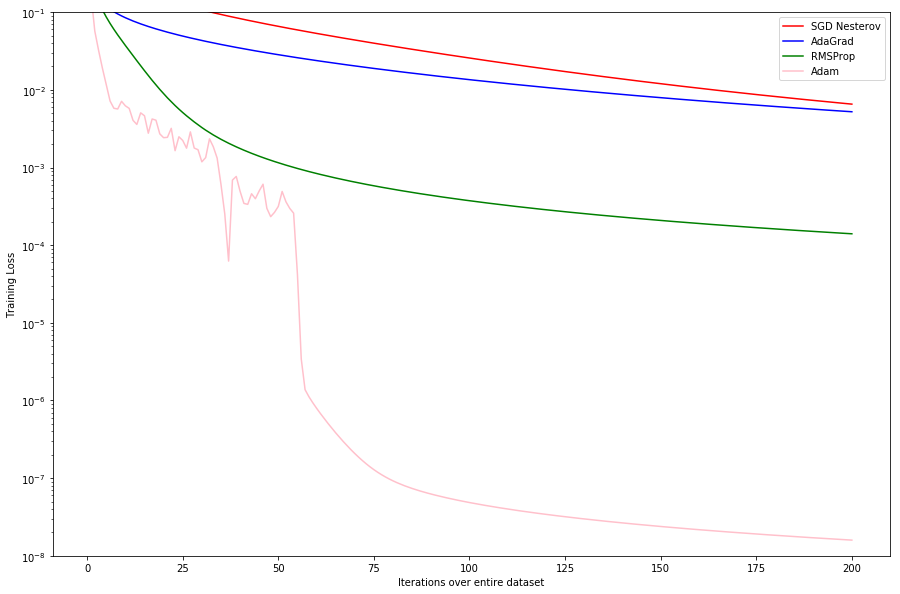

In [49]:
import matplotlib.pyplot as plt

x_axis = numpy.array(list(range(1,n_epochs+1)))
fig = plt.figure(figsize=(15,10))
plt.plot(x_axis, loss_sgdNesterov, color='red', label='SGD Nesterov')
plt.plot(x_axis, loss_adagrad, color='blue', label='AdaGrad')
plt.plot(x_axis, loss_rmsprop, color='green', label='RMSProp')
plt.plot(x_axis, loss_adam, color='pink', label='Adam')
plt.legend(loc=1)
plt.yscale('log')
plt.ylim(1e-8,0.1)
plt.xlabel('Iterations over entire dataset')
plt.ylabel('Training Loss')
plt.show()

**Plot for accuracies.**

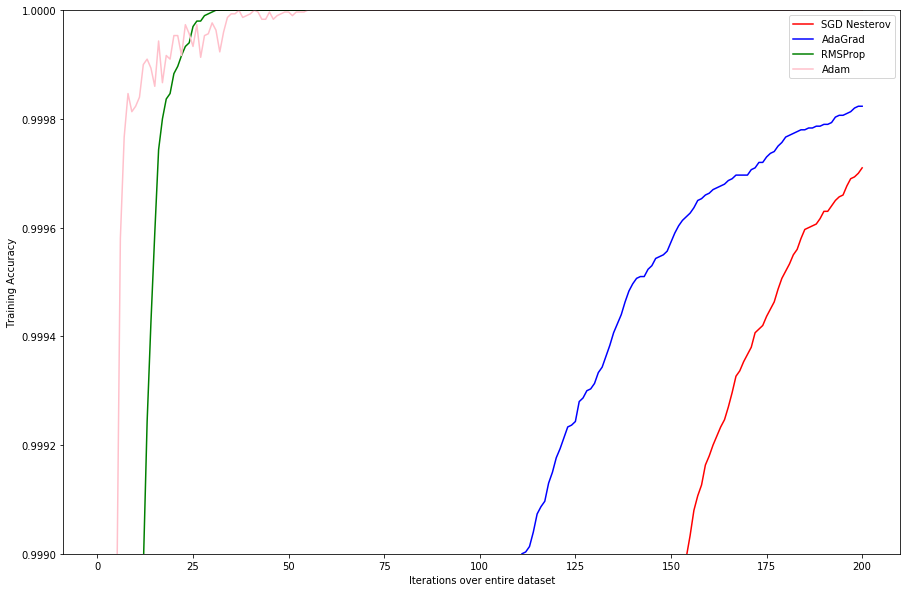

In [50]:
x_axis = numpy.array(list(range(1,n_epochs+1)))
fig = plt.figure(figsize=(15,10))
plt.plot(x_axis, accuracy_sgdNesterov, color='red', label='SGD Nesterov')
plt.plot(x_axis, accuracy_adagrad, color='blue', label='AdaGrad')
plt.plot(x_axis, accuracy_rmsprop, color='green', label='RMSProp')
plt.plot(x_axis, accuracy_adam, color='pink', label='Adam')
plt.legend(loc=1)
plt.ylim(0.999,1)
plt.xlabel('Iterations over entire dataset')
plt.ylabel('Training Accuracy')
plt.show()

# **The results and findings are discussed in the PDF.**